Okay here's what I've learned so far. 002_S_0295 is indeed the subject ID, and 002 is the location. S seems to be universal for each subject, so not really important. The last four digits are the roster ID (whatever that means). The big number in the middle is almost certainly a timestamp, although why it doesn't match up with the folder name is unknown. The second to last number is the Series ID. What that means is unknown. The last one is indeed the image ID, same for all parts of the individual scan.

Notes from meeting with Dr Rhodes


using csv file with file path for each image
building custom class for pytorch

directory with all the pixel matrices using numpy and the 3d matrix

Okay so I've succeeded at writing a script that creates a 3d matrix for each complete scan and an individual pixel matrix for each file in .npy form. It stores them in a directory next to the scan directory. It also writes a .csv file with the path to each 3d matrix file. Running the script for ~ 500 complete scans (so around 80000 individual .dcm files) took ~ 11 minutes.

So with the metadata, I can download a csv with image ID, subject name, research group, along with some other info that seems less important. The scan metadata has two different files for each scan, the small one basically just has labeling info, the bigger one has a lot of other stuff, like APOE, MMSE, GDS, CDR, subject demographic information (including research group), and technical information about the scan itself. I'm not sure how Dr Rhodes would want me to incorporate this information, so I can't move forward quite yet with everything.

Okay I actually have to think some more. Ideally, what would this look like at the end? A model (coded up etc.), a data loader. A CSV file with 

In [4]:
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
import torchvision.models as models
import torch.nn as nn
import torchvision
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Subset
import sys
sys.path.append('/Users/spencerfong/Documents/ADNI Research/MP-Rage Images/3D_Pretrained_Networks')
import importlib
import resnet
importlib.reload(resnet)
from collections import OrderedDict
from sklearn.manifold import TSNE

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
import pydicom as dicom
import matplotlib.pylab as pylab
from os import listdir, walk, path, getcwd
import re
import time
import xml.etree.ElementTree as ET

from PIL import Image
import requests
from io import BytesIO

In [3]:
import warnings
warnings.filterwarnings("ignore")
import pydicom as dicom
import matplotlib.pylab as plt
from os import listdir, walk, path, makedirs
import pandas as pd
import re
import numpy as np
import sys
import time
import xml.etree.ElementTree as ET

In [14]:
target_directory = 'Testing big download/'

In [15]:
class Rage_Scans(Dataset):

    def __init__(self, csv_file, transform=None):
 
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        matrix_path = self.data_frame.iloc[idx, 0]
        label = self.data_frame.iloc[idx, 1]

        matrix = np.load(matrix_path)

        sample = {'matrix': matrix, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [17]:
# Path to your CSV file
csv_file = path.join(target_directory,'ADNI/Images.csv')

# Create the dataset
dataset = Rage_Scans(csv_file=csv_file)

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=5, shuffle=True, num_workers=0)

In [18]:
for i, batch in enumerate(dataloader):
    matrices = batch['matrix']
    labels = batch['label']
    print(f'Batch {i}:')
    print(f'Matrices: {matrices.shape}')
    print(f'Labels: {labels}')

Batch 0:
Matrices: torch.Size([5, 166, 256, 256])
Labels: ['MCI', 'CN', 'MCI', 'MCI', 'CN']
Batch 1:
Matrices: torch.Size([5, 166, 256, 256])
Labels: ['MCI', 'CN', 'MCI', 'CN', 'CN']
Batch 2:
Matrices: torch.Size([5, 166, 256, 256])
Labels: ['MCI', 'AD', 'CN', 'MCI', 'MCI']
Batch 3:
Matrices: torch.Size([5, 166, 256, 256])
Labels: ['CN', 'MCI', 'CN', 'CN', 'CN']
Batch 4:
Matrices: torch.Size([5, 166, 256, 256])
Labels: ['CN', 'CN', 'MCI', 'CN', 'AD']
Batch 5:
Matrices: torch.Size([5, 166, 256, 256])
Labels: ['AD', 'MCI', 'AD', 'MCI', 'CN']
Batch 6:
Matrices: torch.Size([5, 166, 256, 256])
Labels: ['CN', 'CN', 'MCI', 'CN', 'CN']
Batch 7:
Matrices: torch.Size([5, 166, 256, 256])
Labels: ['MCI', 'MCI', 'AD', 'AD', 'MCI']
Batch 8:
Matrices: torch.Size([5, 166, 256, 256])
Labels: ['CN', 'CN', 'CN', 'AD', 'CN']
Batch 9:
Matrices: torch.Size([5, 166, 256, 256])
Labels: ['AD', 'AD', 'AD', 'CN', 'AD']


In [47]:
# Path to your CSV file
csv_file_2d = path.join(target_directory,'ADNI/2d_nn_practice.csv')

# Create the dataset
dataset_2d = Rage_Scans(csv_file=csv_file_2d)

# Create the dataloader
dataloader_2d = DataLoader(dataset_2d, batch_size=5, shuffle=True, num_workers=0)

In [49]:
for i, batch in enumerate(dataloader_2d):
    matrices = batch['matrix']
    labels = batch['label']
    print(f'Batch {i}:')
    print(f'Matrices: {matrices.shape}')
    print(f'Labels: {labels}')

Batch 0:
Matrices: torch.Size([5, 256, 256])
Labels: ['CN', 'AD', 'MCI', 'CN', 'CN']


Put some more meta data in the CSV Files (talk to neuroscience people first)


start with Resnet 50 - Github. importing the model from torchvision

need to one hot encode the labels, output layer will have three classes

input layer will need to be the size of the largest matrices, then zero pad the smaller ones


okay so there is a wide range of possible sizes. Max of 208 slices. Three possible images sizes: 256x256, 256x240, and 192x192.


think about adding in time to the CSV, and MMSE, CDR, APOE 1 and 2.

In [22]:
# pattern3 = re.compile(r'3d_matrix')
# for root, dirs, files in walk(new_directory):
#     for name in files:
#         if name == '.DS_Store':
#             continue
#         if re.search(pattern3, name):
#             #print(path.join(root,name))
#             matrix = np.load(path.join(root,name))
#             print(matrix.shape)

In [ ]:
# This is a bunch of stuff I was trying with converting the layers that won't be relevant anymore

# layer_names = ['conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3']
# for layer in resnet50.layer1:
#     for name, module in layer.named_children():
#         print(name)

# def convert_3d_nn(nn_object):
#     if isinstance(nn_object, models.resnet.ResNet):
#         print("It's a resnet!")
#     else:
#         print('Not a resnet :(')
#         return
#     return

# for name, layer in resnet50.named_children():
#     print(name)

In [6]:
resnet50 = models.resnet50(pretrained=True)

In [1]:
#print(resnet50)

In [13]:
resnet50.fc.out_features=3

resnet50.fc

Linear(in_features=2048, out_features=3, bias=True)

# Okay let's keep working on that TSNE dimensionality reduction

In [144]:
# Updated Rage_Scans with indice based encoding

class Rage_Scans(Dataset):

    def __init__(self, csv_file, transform=None):
        
        self.data_frame = pd.read_csv(csv_file)
        unique_labels = ['CN', 'MCI', 'AD']
        label_to_index = {label: index for index, label in enumerate(unique_labels)}
        self.data_frame['Research Group'] = pd.Series([label_to_index[label] for label in self.data_frame['Research Group']])
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)
        
    # def pad_matrix(matrix):
    #     if matrix.shape == (208, 256, 256):
    #         return matrix
    #     dim1 = matrix.shape[0]
    #     dim2 = matrix.shape[1]
    #     dim3 = matrix.shape[2]
    #     if dim1 != 208:
    #         matrix = np.pad(matrix, ((int((208-dim1)/2),int((208-dim1)/2)),(0,0),(0,0)), 'constant')
    #     if dim2 == 192:
    #         matrix = np.pad(matrix, ((0,0),(32,32),(32,32)), 'constant')
    #         return matrix
    #     if dim3 == 240:
    #         matrix = np.pad(matrix, ((0,0),(0,0),(8,8)), 'constant')
    #     return matrix

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        matrix_path = self.data_frame.iloc[idx, 0]
        label = self.data_frame.iloc[idx, 1]

        matrix = np.load(matrix_path)
        matrix = matrix.astype('float32')
        # matrix = pad_matrix(matrix)

        sample = {'matrix': matrix, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [145]:
dim_reduction_dir = 'Testing big download/'

In [146]:
# Path to your CSV file
csv_file_2d = path.join(dim_reduction_dir,'ADNI/training_loop.csv')

# Create the dataset
dataset_2d = Rage_Scans(csv_file=csv_file_2d)

In [147]:
# create a training, testing, and validation sets

train_size = int(0.66 * len(dataset_2d))
val_size = int(0.17 * len(dataset_2d))
test_size = len(dataset_2d) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset_2d, [train_size, val_size, test_size])

In [148]:
dataloader_2d_test = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [149]:
dim_red_model_weights_path = '2dweights_dim_red.pth'

In [150]:
resnet50 = torch.load(dim_red_model_weights_path, map_location=torch.device('cpu'))

In [151]:
resnet50_dimred = nn.Sequential(*list(resnet50.children())[:-1])

In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [153]:
as_features_list = []
with torch.no_grad():
    for batch in dataloader_2d_test:
        test_matrix = batch['matrix'].to(device, dtype=torch.float32)
        test_matrix = torch.unsqueeze(test_matrix, 1)
        test_label = batch['label']
        features = resnet50_dimred(test_matrix)
        #features = torch.flatten(features, 1)  # Flatten the tensor to get shape [batch_size, 2048]
        as_features_list.append(features)
        #as_features_list.append(test_label)

In [154]:
as_features_list[0].shape

torch.Size([32, 2048, 1, 1])

In [155]:
for i in range(len(as_features_list)):
    as_features_list[i] = torch.flatten(as_features_list[i], 1)

In [156]:
as_features_array = np.concatenate(as_features_list, axis=0)

In [157]:
labels_list = []
for batch in dataloader_2d_test:
    l = batch['label']
    labels_list.append(l)
labels_array = np.concatenate(labels_list, axis=0)

In [185]:
dataset_2d.data_frame.iloc[test_dataset.indices]['File Path'].iloc[1]

'Testing big download/ADNI/002_S_0413/MP-RAGE/2007-06-01_07_04_09.0/I55771_Pixel_Matrices/ADNI_002_S_0413_MR_MP-RAGE__br_raw_20070602193552771_30_S32938_I55771_pm.npy'

In [158]:
patient_id_pattern = re.compile(r'\d{3}_S_\d{4}')
patient_id_list = []

for i in range(len(dataset_2d.data_frame.iloc[test_dataset.indices]['File Path'].reset_index(drop=True))):
    patient_id_list.append(re.search(patient_id_pattern, dataset_2d.data_frame.iloc[test_dataset.indices]['File Path'].reset_index(drop=True)[i]).group())

In [186]:
date_pattern = re.compile(r'20\d{2}-\d{2}-\d{2}')
date_pattern_list = []

for i in range(len(dataset_2d.data_frame.iloc[test_dataset.indices]['File Path'].reset_index(drop=True))):
    date_pattern_list.append(re.search(date_pattern, dataset_2d.data_frame.iloc[test_dataset.indices]['File Path'].reset_index(drop=True)[i]).group())

In [189]:
df_to_export = pd.DataFrame({'Patient_ID':patient_id_list, 'Date':date_pattern_list, 'Labels':labels_array})
df_to_export = pd.concat([df_to_export, pd.DataFrame(as_features_array)],axis=1)

In [192]:
df_to_export.to_csv('Embedded_Features.csv',index=False)

In [19]:
tsne5 = TSNE(n_components=2, perplexity = 5, random_state=42)
tsne10 = TSNE(n_components=2, perplexity = 10, random_state=42)
tsne20 = TSNE(n_components=2, perplexity = 20, random_state=42)
tsne30 = TSNE(n_components=2, perplexity = 30, random_state=42)
tsne40 = TSNE(n_components=2, perplexity = 40, random_state=42)
tsne50 = TSNE(n_components=2, perplexity = 50, random_state=42)

In [20]:
tsne_results5 = tsne5.fit_transform(as_features_array)
tsne_results10 = tsne10.fit_transform(as_features_array)
tsne_results20 = tsne20.fit_transform(as_features_array)
tsne_results30 = tsne30.fit_transform(as_features_array)
tsne_results40 = tsne40.fit_transform(as_features_array)
tsne_results50 = tsne50.fit_transform(as_features_array)

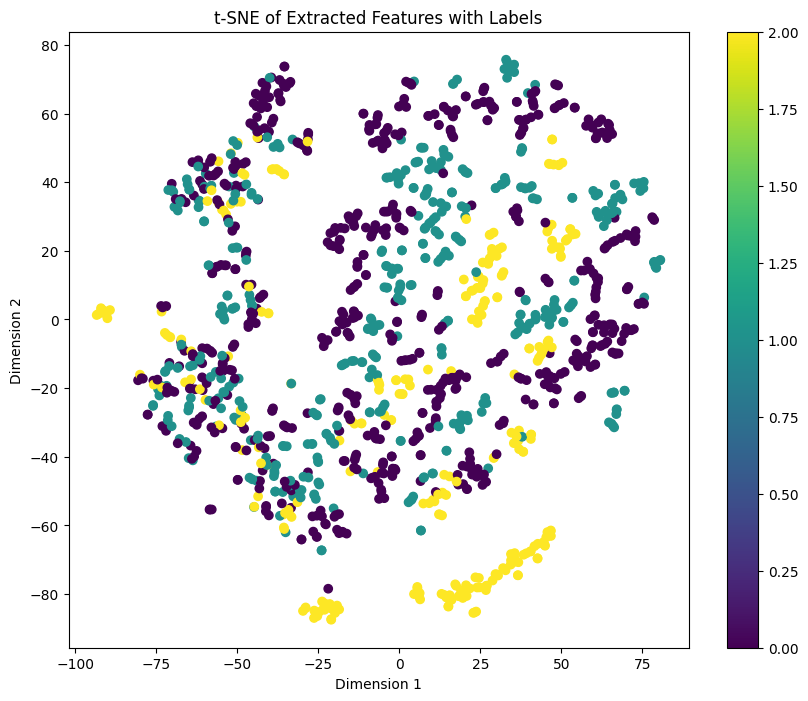

In [21]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results5[:, 0], tsne_results5[:, 1], c=labels_array, cmap='viridis')
plt.title("t-SNE of Extracted Features with Labels")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter)
plt.show()

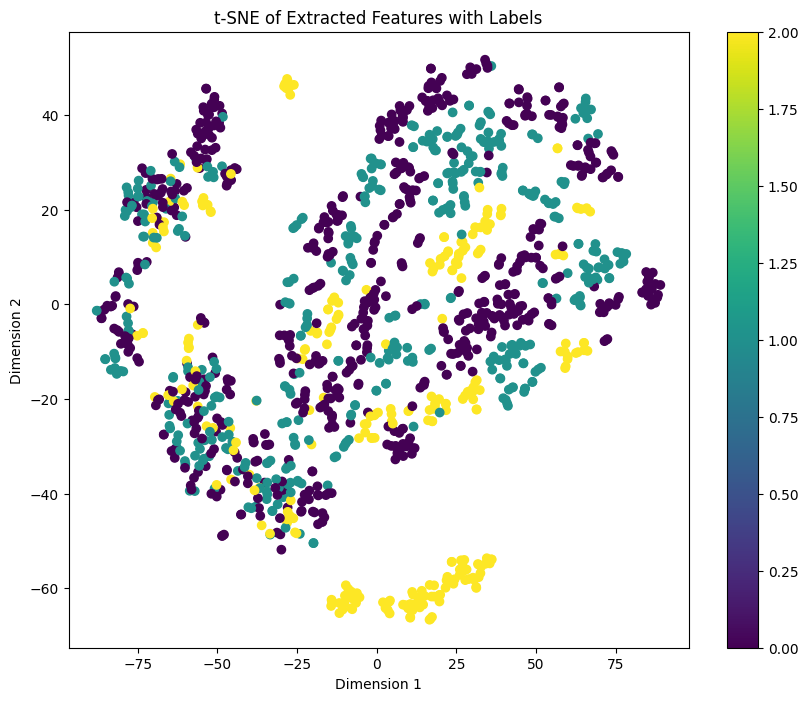

In [22]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results10[:, 0], tsne_results10[:, 1], c=labels_array, cmap='viridis')
plt.title("t-SNE of Extracted Features with Labels")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter)
plt.show()

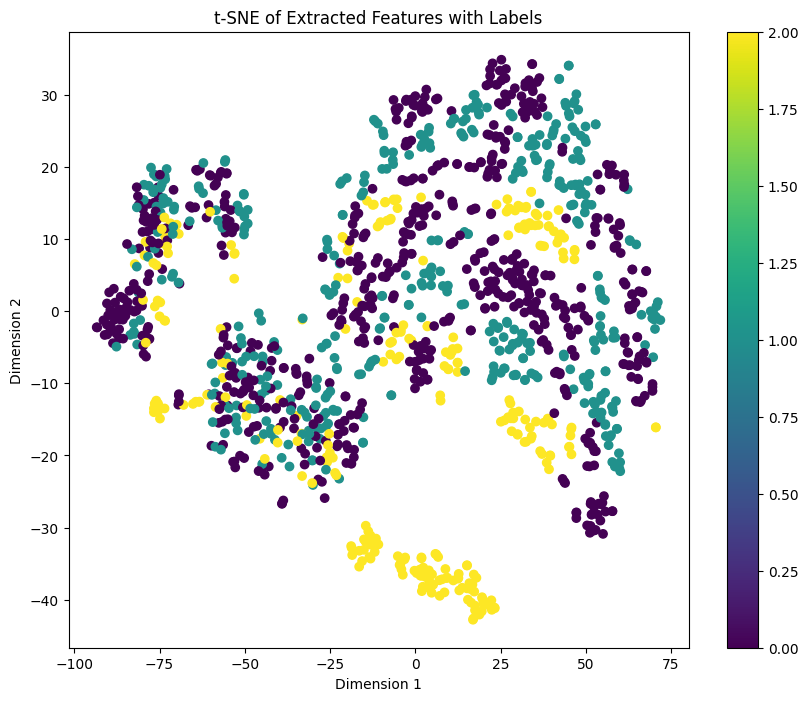

In [23]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results20[:, 0], tsne_results20[:, 1], c=labels_array, cmap='viridis')
plt.title("t-SNE of Extracted Features with Labels")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter)
plt.show()

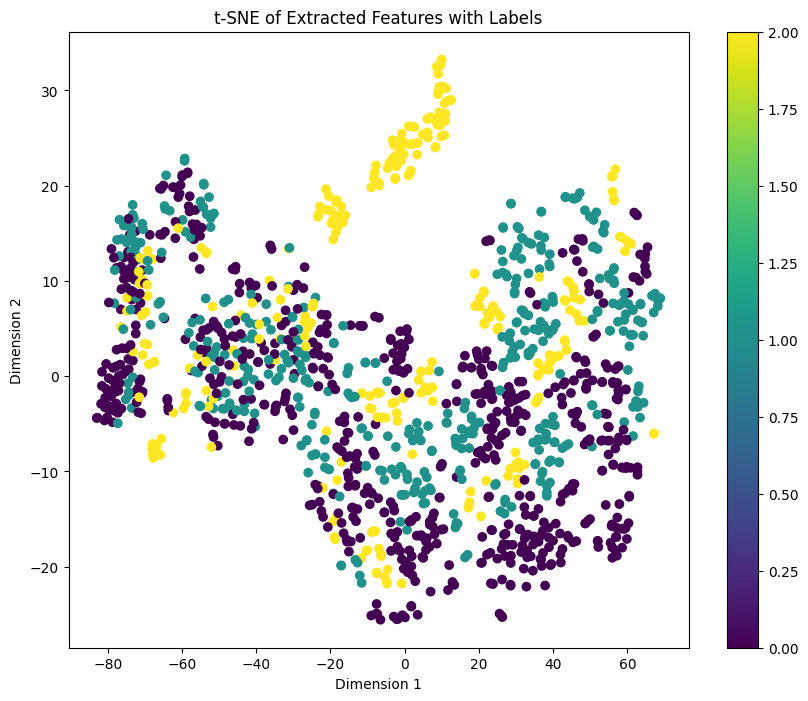

In [24]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results30[:, 0], tsne_results30[:, 1], c=labels_array, cmap='viridis')
plt.title("t-SNE of Extracted Features with Labels")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter)
plt.show()

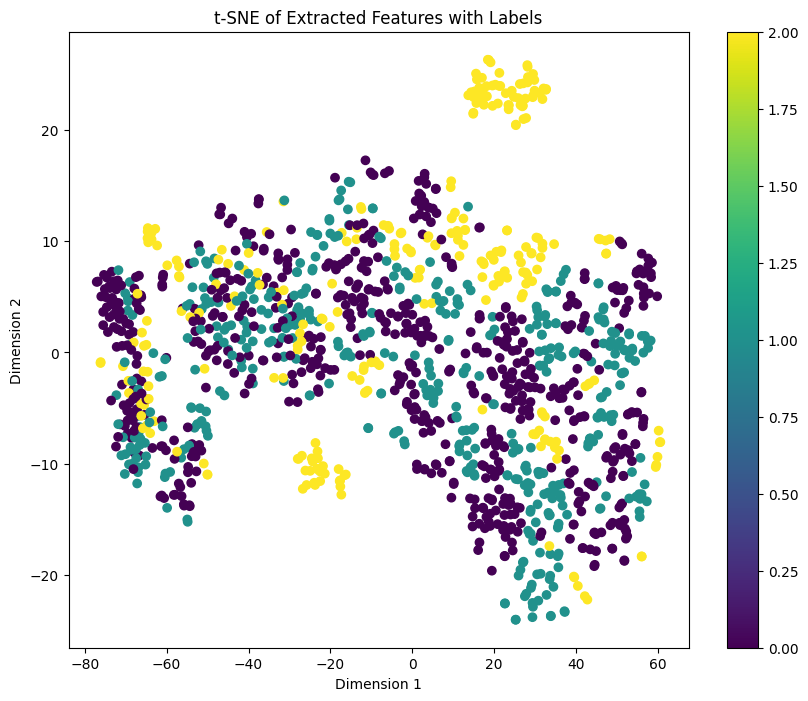

In [25]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results40[:, 0], tsne_results40[:, 1], c=labels_array, cmap='viridis')
plt.title("t-SNE of Extracted Features with Labels")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter)
plt.show()

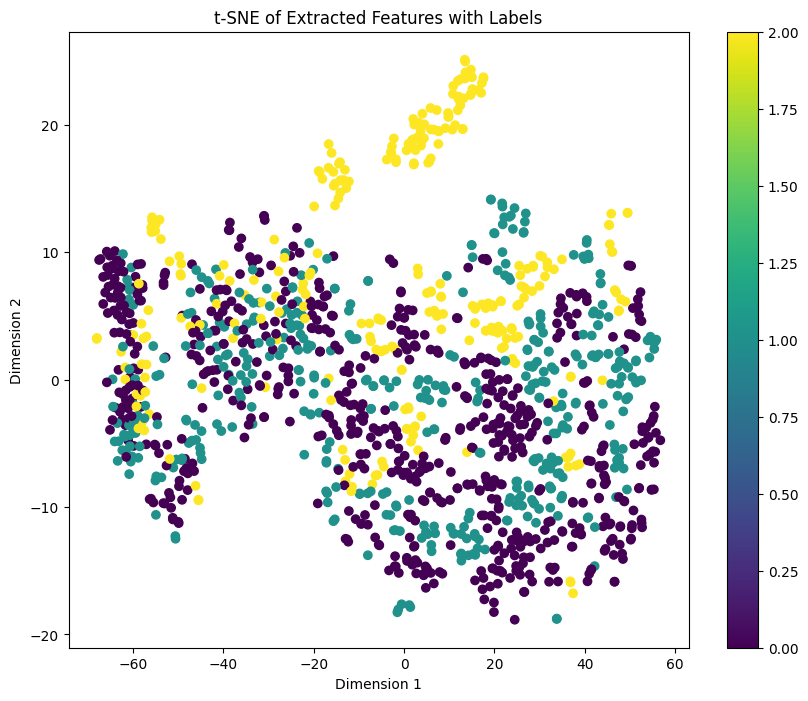

In [26]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results50[:, 0], tsne_results50[:, 1], c=labels_array, cmap='viridis')
plt.title("t-SNE of Extracted Features with Labels")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter)
plt.show()

### More Model Evaluation

In [9]:
dim_reduction_dir = 'Testing big download/'

In [11]:
# Updated Rage_Scans with indice based encoding

class Rage_Scans(Dataset):

    def __init__(self, csv_file, transform=None):
        
        self.data_frame = pd.read_csv(csv_file)
        unique_labels = ['CN', 'MCI', 'AD']
        label_to_index = {label: index for index, label in enumerate(unique_labels)}
        self.data_frame['Research Group'] = pd.Series([label_to_index[label] for label in self.data_frame['Research Group']])
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)
        
    # def pad_matrix(matrix):
    #     if matrix.shape == (208, 256, 256):
    #         return matrix
    #     dim1 = matrix.shape[0]
    #     dim2 = matrix.shape[1]
    #     dim3 = matrix.shape[2]
    #     if dim1 != 208:
    #         matrix = np.pad(matrix, ((int((208-dim1)/2),int((208-dim1)/2)),(0,0),(0,0)), 'constant')
    #     if dim2 == 192:
    #         matrix = np.pad(matrix, ((0,0),(32,32),(32,32)), 'constant')
    #         return matrix
    #     if dim3 == 240:
    #         matrix = np.pad(matrix, ((0,0),(0,0),(8,8)), 'constant')
    #     return matrix

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        matrix_path = self.data_frame.iloc[idx, 0]
        label = self.data_frame.iloc[idx, 1]

        matrix = np.load(matrix_path)
        matrix = matrix.astype('float32')
        # matrix = pad_matrix(matrix)

        sample = {'matrix': matrix, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [12]:
# Path to your CSV file
csv_file_2d = path.join(dim_reduction_dir,'ADNI/training_loop.csv')

# Create the dataset
dataset_2d = Rage_Scans(csv_file=csv_file_2d)

In [13]:
# create a training, testing, and validation sets

train_size = int(0.66 * len(dataset_2d))
val_size = int(0.17 * len(dataset_2d))
test_size = len(dataset_2d) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset_2d, [train_size, val_size, test_size])

In [14]:
dim_red_model_weights_path = '2dweights_dim_red.pth'

In [15]:
resnet50 = torch.load(dim_red_model_weights_path, map_location=torch.device('cpu'))

In [32]:
dataloader_2d_test = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [35]:
labels_list = []
for batch in dataloader_2d_test:
    l = batch['label']
    labels_list.append(l)
labels_array = np.concatenate(labels_list, axis=0)

In [58]:
resnet50.eval()

incorrect_classifications = []
predictions_list = []
right_or_wrong = []

total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch in dataloader_2d_test:
        test_matrix = batch['matrix']#.to(device, dtype=torch.float32)
        test_labels = batch['label']#.to(device, dtype=torch.long)
        test_matrix = torch.unsqueeze(test_matrix, 1)
        test_outputs = resnet50(test_matrix)
        _, test_predicted = torch.max(test_outputs, 1)
        predictions_list.append(test_predicted)
        total_samples += test_labels.size(0)
        total_correct += (test_predicted == test_labels).sum().item()
        right_or_wrong.append(test_predicted == test_labels)
        for i in range(len(test_predicted == test_labels)):
            if (test_predicted == test_labels)[i] == False:
                incorrect_classifications.append(test_matrix[i])
        #print(test_predicted == test_labels)
        #print(test_matrix.shape)
predictions_array = np.concatenate(predictions_list, axis=0)
right_or_wrong_array = np.concatenate(right_or_wrong, axis=0)

In [138]:
incorrect_classifications[0][0]

tensor([[  0.,   0.,   0.,  ...,  15.,  15.,  12.],
        [  0.,   0.,   0.,  ...,  14.,  16.,  12.],
        [ 43.,  48.,  52.,  ...,  74.,  70.,  71.],
        ...,
        [191., 206., 100.,  ..., 151., 151., 115.],
        [ 78.,  74.,  63.,  ...,  78.,  78.,  80.],
        [ 73.,  73.,  55.,  ...,  73.,  57.,  78.]])

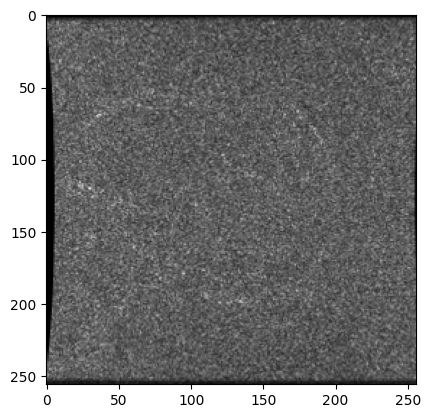

In [142]:
#for i in range(len(incorrect_classifications)):
plt.imshow(incorrect_classifications[20][0],cmap='gray')

In [33]:
slice_pattern = re.compile(r'ADNI_.+_.+_.+_.+_.+__.+_.+_.+_(\d+)_.+_.+')
slice_list = []

for i in range(len(dataset_2d.data_frame.iloc[test_dataset.indices]['File Path'].reset_index(drop=True))):
    slice_list.append(re.search(slice_pattern, dataset_2d.data_frame.iloc[test_dataset.indices]['File Path'].reset_index(drop=True)[i]).group(1))
    #print(re.search(slice_pattern, dataset_2d.data_frame.iloc[test_dataset.indices]['File Path'].reset_index(drop=True)[i]).group(1))

In [64]:
analysis_df = pd.DataFrame({'Slice': slice_list, 'Label': labels_array, 'Prediction': predictions_array, 'Correct': right_or_wrong_array})

In [143]:
analysis_df

,Slice,Label,Prediction,Correct
0,38,0,0,True
1,36,0,0,True
2,79,2,2,True
3,41,0,0,True
4,23,0,0,True
...,...,...,...,...
1406,73,0,0,True
1407,66,2,2,True
1408,127,1,1,True
1409,12,0,0,True


In [89]:
analysis_df['Slice'] = [int(string) for string in analysis_df['Slice']]

In [101]:
#pd.reset_option('display.max_rows')
to_visualize = analysis_df[analysis_df['Correct'] == False]['Slice']

(array([26., 25., 16., 15., 12.,  6.,  6.,  7.,  4.,  7.,  8.,  8.,  2.,
         7.,  5.,  8., 22., 17., 14., 27.]),
 array([  1.  ,   9.25,  17.5 ,  25.75,  34.  ,  42.25,  50.5 ,  58.75,
         67.  ,  75.25,  83.5 ,  91.75, 100.  , 108.25, 116.5 , 124.75,
        133.  , 141.25, 149.5 , 157.75, 166.  ]),
 <BarContainer object of 20 artists>)

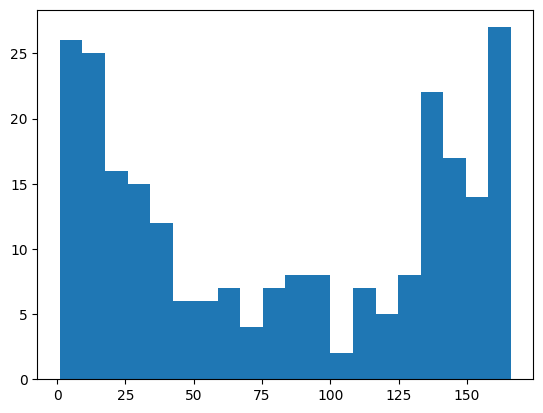

In [117]:
plt.hist(to_visualize,bins=20)

## Using the analysis information

So it's pretty clear that the edge slices are not helpful. They could probably be excluded. We will try this now.

In [451]:
# Updated Rage_Scans with indice based encoding

class Rage_Scans(Dataset):

    def __init__(self, csv_file, transform=None):
        
        self.data_frame = pd.read_csv(csv_file)
        unique_labels = ['CN', 'MCI', 'AD']
        label_to_index = {label: index for index, label in enumerate(unique_labels)}
        self.data_frame['Research Group'] = pd.Series([label_to_index[label] for label in self.data_frame['Research Group']])
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)
        
    # def pad_matrix(matrix):
    #     if matrix.shape == (208, 256, 256):
    #         return matrix
    #     dim1 = matrix.shape[0]
    #     dim2 = matrix.shape[1]
    #     dim3 = matrix.shape[2]
    #     if dim1 != 208:
    #         matrix = np.pad(matrix, ((int((208-dim1)/2),int((208-dim1)/2)),(0,0),(0,0)), 'constant')
    #     if dim2 == 192:
    #         matrix = np.pad(matrix, ((0,0),(32,32),(32,32)), 'constant')
    #         return matrix
    #     if dim3 == 240:
    #         matrix = np.pad(matrix, ((0,0),(0,0),(8,8)), 'constant')
    #     return matrix

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        matrix_path = self.data_frame.iloc[idx, 0]
        label = self.data_frame.iloc[idx, 1]

        matrix = np.load(matrix_path)
        matrix = matrix.astype('float32')
        # matrix = pad_matrix(matrix)

        sample = {'matrix': matrix, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [452]:
# Path to your CSV file
csv_file_2d = path.join(dim_reduction_dir,'ADNI/training_loop.csv')

# Put into Data Frame to filter out unwanted slices
slice_filtering = pd.read_csv(csv_file_2d)

# regex pattern for slices
slice_pattern = re.compile(r'ADNI_.+_.+_.+_.+_.+__.+_.+_.+_(\d+)_.+_.+')

In [453]:
# Filter out rows with unwanted slices
for i in range(len(slice_filtering)):
    slice = int(re.search(slice_pattern, slice_filtering['File Path'][i]).group(1))
    if slice <= 32 or slice >= 125:
        slice_filtering.drop(i,inplace=True)

In [454]:
# Reset index for clean data

slice_filtering.reset_index(inplace=True,drop=True)

# Read to csv file to read back into dataset

slice_filtering.to_csv(path.join(dim_reduction_dir + 'ADNI', 'filtered_slices.csv'),index=False)

In [455]:
# Create the dataset
filtered_csv = path.join(dim_reduction_dir,'ADNI/filtered_slices.csv')

dataset_2d = Rage_Scans(csv_file=filtered_csv)

In [456]:
# create a training, testing, and validation sets

train_size = int(0.66 * len(dataset_2d))
val_size = int(0.17 * len(dataset_2d))
test_size = len(dataset_2d) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset_2d, [train_size, val_size, test_size])

In [458]:
# create the data loader for the training set and validation set
dataloader_2d_train = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
dataloader_2d_val = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)
dataloader_2d_test = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0)

So what I'm doing here is retraining with frozen layers the pytorch pretrained resnet50 with the 2d dataset minus the less helpful slices. Another thing I could do is train it with everything and then filter out the bad slices when evaluating the test dataset. 

In [459]:
# load in pretrained resnet50
resnet50_pytorch_pretrained = models.resnet50(pretrained=True)
# set the first layer to accept 1 channel (grayscale) instead of 3. Not super sure of all the details going on.
original_conv1 = resnet50_pytorch_pretrained.conv1
resnet50_pytorch_pretrained.conv1 = nn.Conv2d(1, original_conv1.out_channels, kernel_size=original_conv1.kernel_size,
                           stride=original_conv1.stride, padding=original_conv1.padding, bias=False)

with torch.no_grad():
    resnet50_pytorch_pretrained.conv1.weight = nn.Parameter(original_conv1.weight.sum(dim=1, keepdim=True))

# set device
device = 'cpu'

# set number of classes to 3
num_ftrs = resnet50_pytorch_pretrained.fc.in_features
resnet50_pytorch_pretrained.fc = nn.Linear(num_ftrs, 3)

In [461]:
# set it to eval mode (for training)
resnet50_pytorch_pretrained.eval()
# run it on cpu if cuda (gpu) not available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# put resnet50 onto cpu
resnet50_pytorch_pretrained = resnet50_pytorch_pretrained.to(device)

# freezing all layers but the final
for param in resnet50_pytorch_pretrained.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer
resnet50_pytorch_pretrained.fc.weight.requires_grad = True
resnet50_pytorch_pretrained.fc.bias.requires_grad = True

#for name, param in resnet50.named_parameters():
#    print(name, param.requires_grad)

# Setting the loss function and optimizer
loss = nn.CrossEntropyLoss()
#optimizer = optim.Adam(resnet50.parameters(), lr=0.001)
optimizer = optim.Adam(resnet50_pytorch_pretrained.fc.parameters(), lr=0.001)

# set epochs
num_epochs = 7
start_time = time.time()
# Training loop
for epoch in range(num_epochs):
    resnet50_pytorch_pretrained.train()
    running_loss = 0.0
    for i, batch in enumerate(dataloader_2d_train):
        matrix = batch['matrix'].to(device, dtype=torch.float32)
        label= batch['label'].to(device, dtype=torch.long)
        matrix = torch.unsqueeze(matrix,1)
        optimizer.zero_grad()
        outputs = resnet50_pytorch_pretrained(matrix)
        batch_loss = loss(outputs,label)
        batch_loss.backward()
        optimizer.step()
        running_loss+=batch_loss
        if i % 10 == 9:  # Print every 10 batches
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader_2d_train)}], Loss: {running_loss:.4f}')
    
    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss / len(dataloader_2d_train):.4f}')

    # Validation phase
    resnet50_pytorch_pretrained.eval()
    val_loss = 0.0
    val_total_correct = 0
    val_total_samples = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader_2d_val):
            val_matrix = batch['matrix'].to(device, dtype=torch.float32)
            val_label= batch['label'].to(device, dtype=torch.long)
            val_matrix = torch.unsqueeze(val_matrix,1)
            val_outputs = resnet50_pytorch_pretrained(val_matrix)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total_samples += val_label.size(0)
            val_total_correct += (val_predicted == val_label).sum().item()
            #val_batch_loss = loss(val_outputs, val_label)
            #val_loss += val_batch_loss
    
    #avg_val_loss = val_loss / len(dataloader_2d_val)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] Val Accuracy: {val_total_correct/val_total_samples:.4f}')

print('Training complete')
end_time = time.time()
end_time - start_time

Epoch [1/7], Step [10/95], Loss: 8.2773
Epoch [1/7], Step [20/95], Loss: 15.9564
Epoch [1/7], Step [30/95], Loss: 23.6739
Epoch [1/7], Step [40/95], Loss: 31.0610
Epoch [1/7], Step [50/95], Loss: 38.8956
Epoch [1/7], Step [60/95], Loss: 45.8422
Epoch [1/7], Step [70/95], Loss: 52.6132
Epoch [1/7], Step [80/95], Loss: 58.7709
Epoch [1/7], Step [90/95], Loss: 64.8500
Epoch [1/7] Loss: 0.7093
Epoch [1/7] Val Accuracy: 0.8223
Epoch [2/7], Step [10/95], Loss: 5.2885
Epoch [2/7], Step [20/95], Loss: 10.4342
Epoch [2/7], Step [30/95], Loss: 16.0088
Epoch [2/7], Step [40/95], Loss: 21.4970
Epoch [2/7], Step [50/95], Loss: 26.2558
Epoch [2/7], Step [60/95], Loss: 31.5785
Epoch [2/7], Step [70/95], Loss: 36.7789
Epoch [2/7], Step [80/95], Loss: 41.9804
Epoch [2/7], Step [90/95], Loss: 46.8499
Epoch [2/7] Loss: 0.5202
Epoch [2/7] Val Accuracy: 0.8453
Epoch [3/7], Step [10/95], Loss: 4.3798
Epoch [3/7], Step [20/95], Loss: 8.7691
Epoch [3/7], Step [30/95], Loss: 12.9299
Epoch [3/7], Step [40/95], 

4082.455374956131

In [462]:
resnet50_pytorch_pretrained.eval()

total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch in dataloader_2d_test:
        test_matrix = batch['matrix'].to(device, dtype=torch.float32)
        test_labels = batch['label'].to(device, dtype=torch.long)
        test_matrix = torch.unsqueeze(test_matrix, 1)
        test_outputs = resnet50_pytorch_pretrained(test_matrix)
        _, test_predicted = torch.max(test_outputs, 1)
        total_samples += test_labels.size(0)
        total_correct += (test_predicted == test_labels).sum().item()

In [463]:
total_correct / total_samples

0.90153452685422

In [464]:
torch.save(resnet50_pytorch_pretrained, 'Models/90%_32-125.pth')

Okay now try again but just using the already saved one and cutting out some slices






In [263]:
# Path to your CSV file
csv_file_2d = path.join(dim_reduction_dir,'ADNI/training_loop.csv')

# Create the dataset
dataset_2d = Rage_Scans(csv_file=csv_file_2d)

In [376]:
# create a training, testing, and validation sets
torch.manual_seed(42)

train_size = int(0.66 * len(dataset_2d))
val_size = int(0.17 * len(dataset_2d))
test_size = len(dataset_2d) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset_2d, [train_size, val_size, test_size])

In [377]:
torch.manual_seed(42)
dataloader_2d_test = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [360]:
filter_slices = dataset_2d.data_frame.iloc[test_dataset.indices].reset_index()

In [361]:
slice_pattern = re.compile(r'ADNI_.+_.+_.+_.+_.+__.+_.+_.+_(\d+)_.+_.+')
slice_list = []

for i in range(len(filter_slices['File Path'])):
    slice_list.append(int(re.search(slice_pattern, filter_slices['File Path'][i]).group(1)))
    #print(re.search(slice_pattern, dataset_2d.data_frame.iloc[test_dataset.indices]['File Path'].reset_index(drop=True)[i]).group(1))
filter_slices['Slice'] = slice_list

In [446]:
new_indices = list(filter_slices[(filter_slices['Slice'] >= 32) & (filter_slices['Slice'] <= 122)]['index'])

In [447]:
len(new_indices)

786

In [448]:
subset_dataset = Subset(dataset_2d, new_indices)
torch.manual_seed(42)
subset_loader = DataLoader(subset_dataset, batch_size=32, shuffle=False)

In [449]:
resnet50.eval()

total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch in subset_loader:
        test_matrix = batch['matrix'].to(device, dtype=torch.float32)
        test_labels = batch['label'].to(device, dtype=torch.long)
        test_matrix = torch.unsqueeze(test_matrix, 1)
        test_outputs = resnet50_pytorch_pretrained(test_matrix)
        _, test_predicted = torch.max(test_outputs, 1)
        total_samples += test_labels.size(0)
        total_correct += (test_predicted == test_labels).sum().item()

In [450]:
total_correct / total_samples

0.9325699745547074

35-130: 93.27%

40-130: 93.0%

33-130: 93.2%

33-125: 93.28%

32-125: 93.3%

Okay now let's do a TSNE with the model that got 90% on the filtered slices

In [467]:
# Create the dataset
filtered_csv = path.join(dim_reduction_dir,'ADNI/filtered_slices.csv')

dataset_2d = Rage_Scans(csv_file=filtered_csv)

In [492]:
# create a training, testing, and validation sets

train_size = int(0.66 * len(dataset_2d))
val_size = int(0.17 * len(dataset_2d))
test_size = len(dataset_2d) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset_2d, [train_size, val_size, test_size])

In [493]:
dataloader_2d_test = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [494]:
resnet50_dimred = nn.Sequential(*list(resnet50_pytorch_pretrained.children())[:-1])

In [495]:
as_features_list = []
with torch.no_grad():
    for batch in dataloader_2d_test:
        test_matrix = batch['matrix'].to(device, dtype=torch.float32)
        test_matrix = torch.unsqueeze(test_matrix, 1)
        test_label = batch['label']
        features = resnet50_dimred(test_matrix)
        as_features_list.append(features)

In [496]:
as_features_list[0].shape

torch.Size([32, 2048, 1, 1])

In [497]:
for i in range(len(as_features_list)):
    as_features_list[i] = torch.flatten(as_features_list[i], 1)
as_features_array = np.concatenate(as_features_list, axis=0)
labels_list = []
for batch in dataloader_2d_test:
    l = batch['label']
    labels_list.append(l)
labels_array = np.concatenate(labels_list, axis=0)

In [498]:
tsne5 = TSNE(n_components=2, perplexity = 5, random_state=42)
tsne10 = TSNE(n_components=2, perplexity = 10, random_state=42)
tsne20 = TSNE(n_components=2, perplexity = 20, random_state=42)
tsne30 = TSNE(n_components=2, perplexity = 30, random_state=42)
tsne40 = TSNE(n_components=2, perplexity = 40, random_state=42)
tsne50 = TSNE(n_components=2, perplexity = 50, random_state=42)

In [499]:
tsne_results5 = tsne5.fit_transform(as_features_array)
tsne_results10 = tsne10.fit_transform(as_features_array)
tsne_results20 = tsne20.fit_transform(as_features_array)
tsne_results30 = tsne30.fit_transform(as_features_array)
tsne_results40 = tsne40.fit_transform(as_features_array)
tsne_results50 = tsne50.fit_transform(as_features_array)

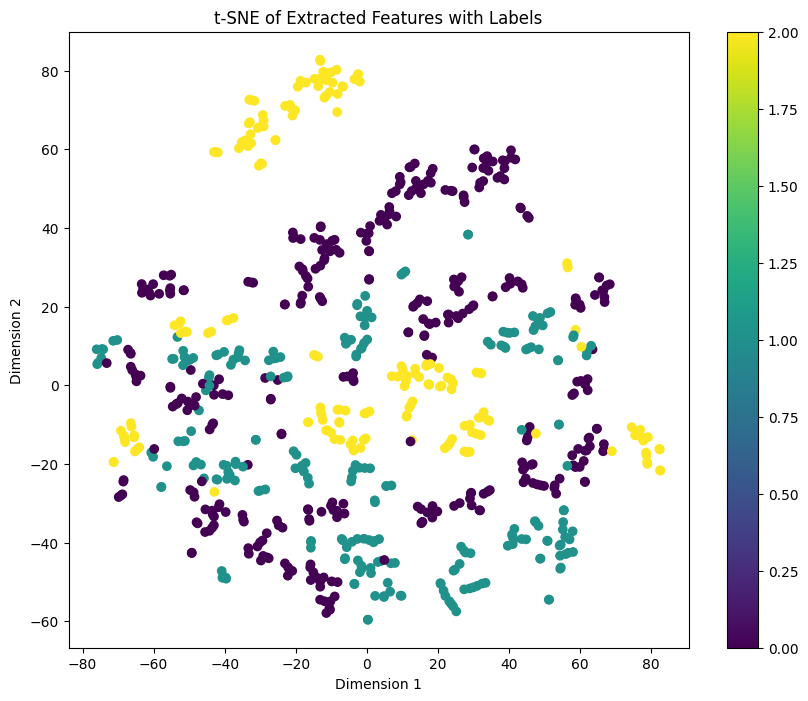

In [500]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results5[:, 0], tsne_results5[:, 1], c=labels_array, cmap='viridis')
plt.title("t-SNE of Extracted Features with Labels")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter)
plt.show()

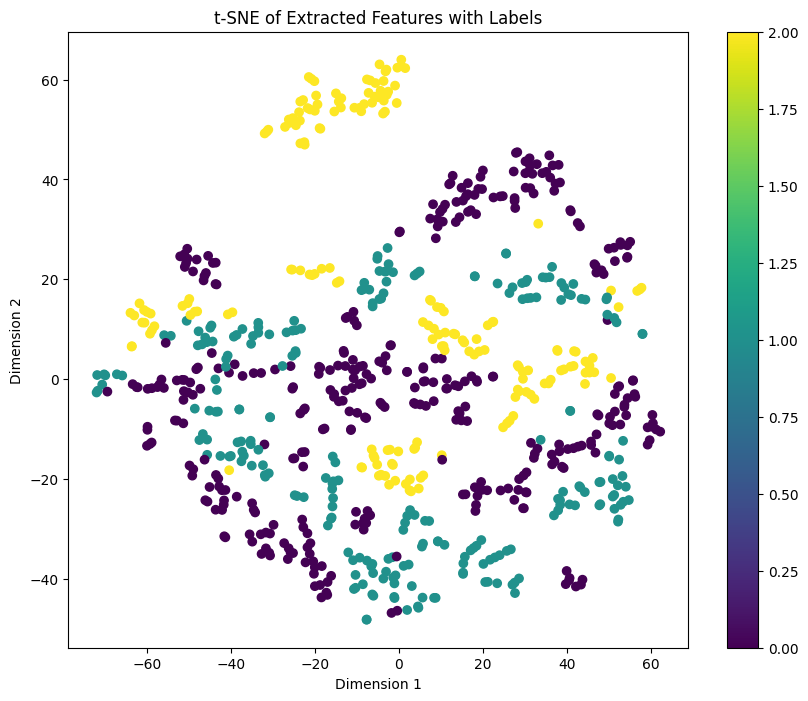

In [501]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results10[:, 0], tsne_results10[:, 1], c=labels_array, cmap='viridis')
plt.title("t-SNE of Extracted Features with Labels")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter)
plt.show()

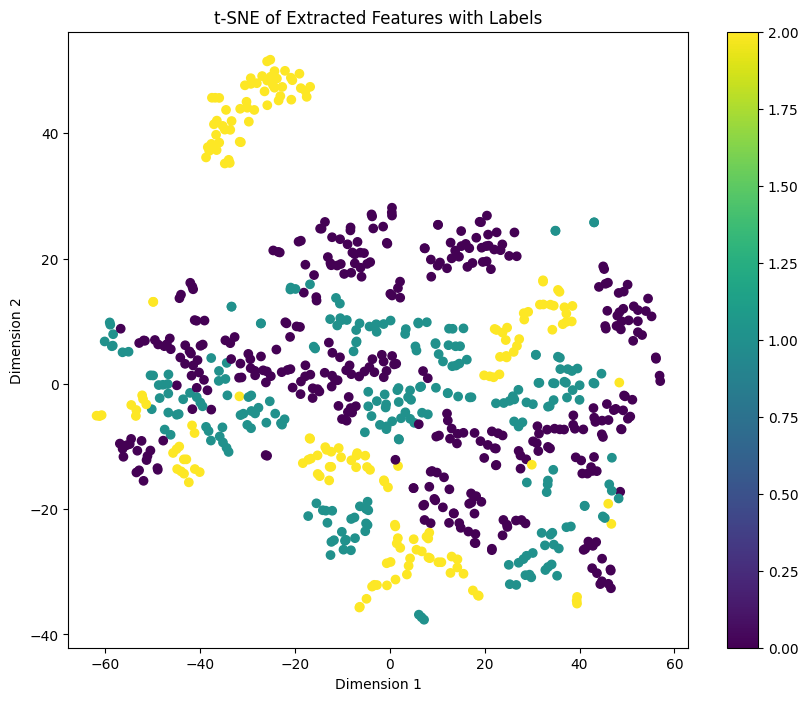

In [502]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results20[:, 0], tsne_results20[:, 1], c=labels_array, cmap='viridis')
plt.title("t-SNE of Extracted Features with Labels")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter)
plt.show()

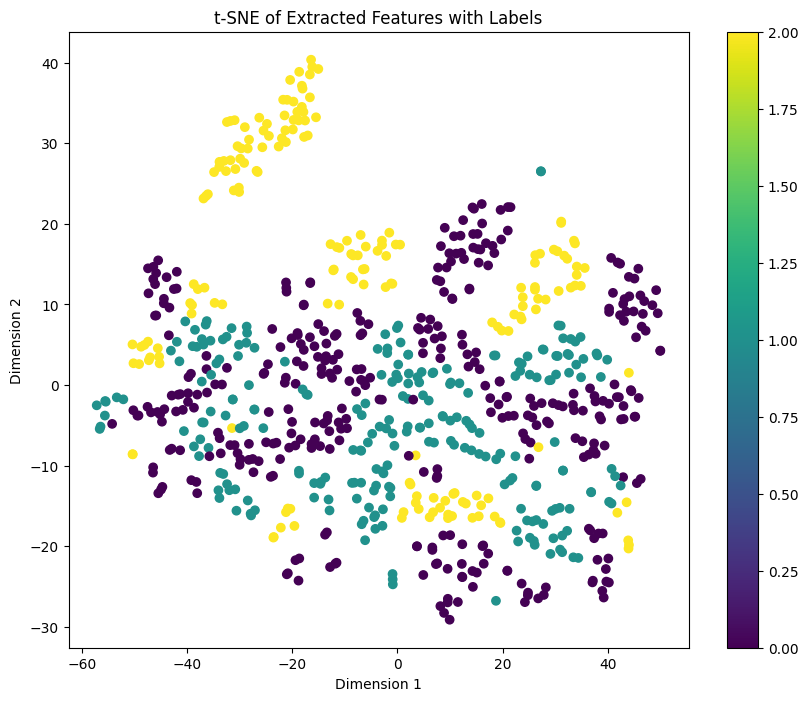

In [503]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results30[:, 0], tsne_results30[:, 1], c=labels_array, cmap='viridis')
plt.title("t-SNE of Extracted Features with Labels")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter)
plt.show()

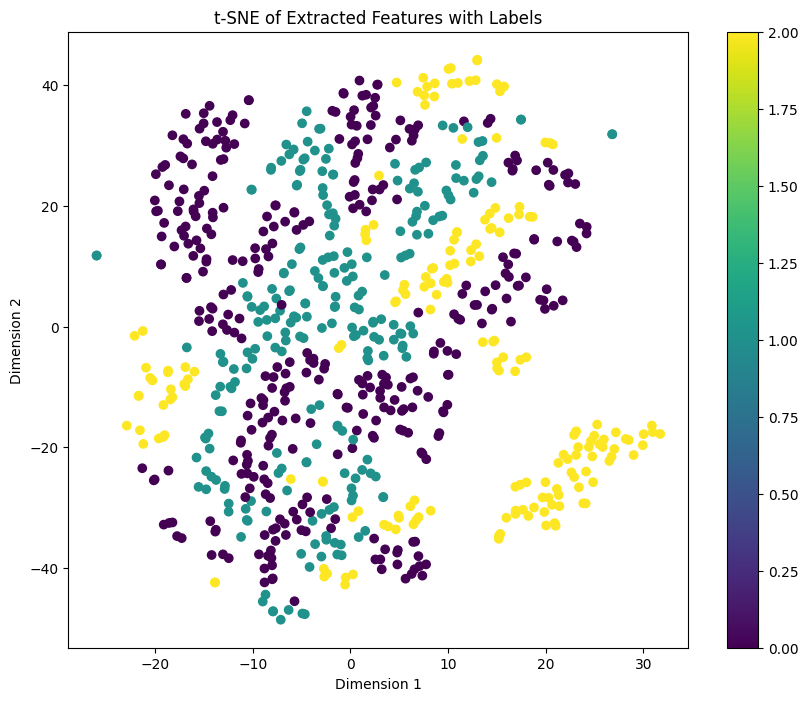

In [504]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results40[:, 0], tsne_results40[:, 1], c=labels_array, cmap='viridis')
plt.title("t-SNE of Extracted Features with Labels")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter)
plt.show()

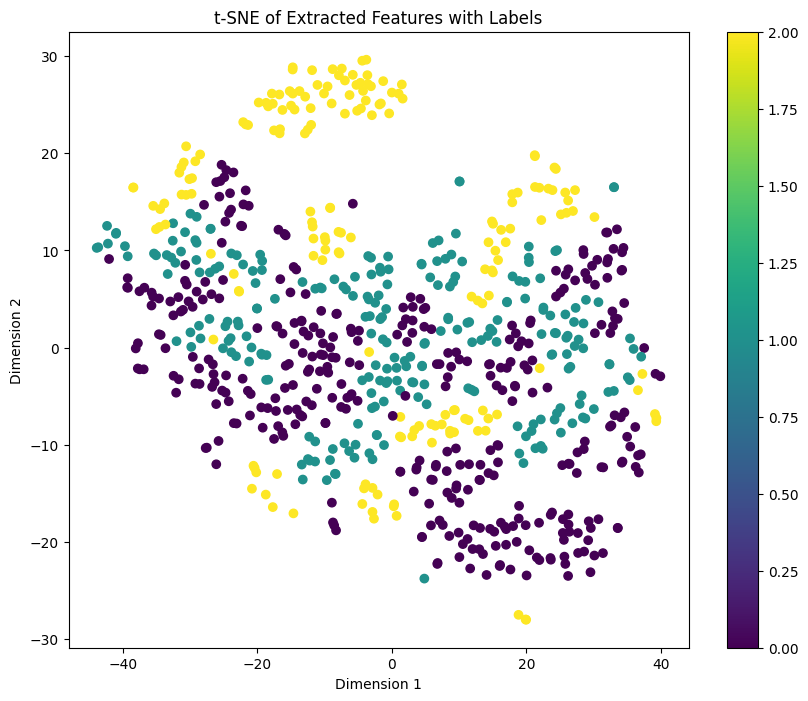

In [505]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results50[:, 0], tsne_results50[:, 1], c=labels_array, cmap='viridis')
plt.title("t-SNE of Extracted Features with Labels")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter)
plt.show()

look at one patient with TSNE, color by visit, and see if their visits clump or are all mixed together. Could provide some insights into if their data is changing.